#### Step 1 : Clean and normalise data

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations
import seaborn as sns
import ast

In [2]:
#Read the dataset

df = pd.read_csv("dataset\steam_dataset_2025.csv", encoding="cp1252", sep=';')

df.head()

,appid,name,release_date,price,dlc_count,reviews,metacritic_score,recommendations,categories,genres,...,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
0,730,Counter-Strike 2,21/08/2012,0.00,1,NaN,0,4401572,"['Multi-player', 'Cross-Platform Multiplayer',...","['Action', 'Free To Play']",...,33189,879,5174,350,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",86,8632939,82,96473
1,578080,PUBG: BATTLEGROUNDS,21/12/2017,0.00,0,NaN,0,1732007,"['Multi-player', 'PvP', 'Online PvP', 'Stats',...","['Action', 'Adventure', 'Massively Multiplayer...",...,0,0,0,0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",59,2513842,68,16720
2,570,Dota 2,09/07/2013,0.00,2,“A modern multiplayer masterpiece.” 9.5/10 – D...,90,14337,"['Multi-player', 'Co-op', 'Steam Trading Cards...","['Action', 'Strategy', 'Free To Play']",...,43031,1536,898,892,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",81,2452595,80,29366
3,271590,Grand Theft Auto V Legacy,13/04/2015,0.00,0,NaN,96,1803063,"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Action', 'Adventure']",...,19323,771,7101,74,117698,"{'Open World': 32644, 'Action': 23539, 'Multip...",87,1803832,92,17517
4,359550,Tom Clancy's Rainbow Six® Siege,01/12/2015,3.99,9,NaN,0,1165929,"['Single-player', 'Multi-player', 'PvP', 'Onli...",['Action'],...,14204,682,2434,306,89916,"{'FPS': 9831, 'PvP': 9162, 'e-sports': 9072, '...",84,1168020,76,12608


In [3]:
#Checking info on the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89618 entries, 0 to 89617
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   appid                     89618 non-null  int64  
 1   name                      89618 non-null  object 
 2   release_date              89618 non-null  object 
 3   price                     89618 non-null  float64
 4   dlc_count                 89618 non-null  int64  
 5   reviews                   10401 non-null  object 
 6   metacritic_score          89618 non-null  int64  
 7   recommendations           89618 non-null  int64  
 8   categories                89618 non-null  object 
 9   genres                    89618 non-null  object 
 10  positive                  89618 non-null  int64  
 11  negative                  89618 non-null  int64  
 12  estimated_owners          89618 non-null  object 
 13  average_playtime_forever  89618 non-null  int64  
 14  averag

A lot of reviews are missing, and a lot of elements are described as 'non-null', but are in fact '0', which can be described as null.

For exampe, Metacritic doesn't usually give 0 score, but there are many 0s in 'metacritic_score'.  It isn't normal that PUBG or Country Strike 2, which are very popular shooting games, have 0. Thus, the information mustn't have been found, and 0 was instead given to indicate a missing value. That is why 0 mustn't be considered bad grades, but rather, skippable grades.

While metacritic_score could have been an interesting category for predictions, there are too many 0s, as indicated in the following cell.

That is why we must **remove the columns that may add noise, and remove the insignificant columns.**

**Remove:**
- name, appid, price, dlc_count, reviews, metacritic_score, average_playtime & median_playtime 2 weeks, pct_pos_recent, num_reviews_recent.

"Recent" columns are not precise enough, since the dataset is several months old, the numbers might have changed by a lot, and games lost popularity. It is better to stick to overall numbers like totals.

In [5]:
df['metacritic_score'].value_counts(normalize=True)

#'0' = 96%. We're better off deleting this category, instead of finding the scores.

metacritic_score
0     0.960421
80    0.002176
81    0.001886
78    0.001819
76    0.001774
        ...   
23    0.000011
20    0.000011
29    0.000011
35    0.000011
30    0.000011
Name: proportion, Length: 69, dtype: float64

In [3]:
# Removing unnecessary columns

df = df.drop(["appid", "price", "dlc_count", "metacritic_score", "reviews", "average_playtime_2weeks", "median_playtime_2weeks", "pct_pos_recent", "num_reviews_recent"], axis=1)


# Remodelling release_date: 01/01/2015 -> 2015

df['release_date'] = df['release_date'].str.split(pat="/", expand=True)[2].astype("int64") 
df.rename(columns={"release_date":"release_year"}, inplace=True)
df = df.query("release_year >= 2015") #We only keep data after 2015, since that's our main interest for this study


# Modify 'estimated_owners' aspect : split the column into two separate columns 'owners_low' and 'owners_high' + fix to the right datatype

df[['owners_low', 'owners_high']] = df["estimated_owners"].str.split(" - ", expand=True).astype(int)

# Quickly create a new column for the total mean average owners per game
# For this training project, while getting an average might not be accurate for the later results, I am simply keeping it clean and simple.
df = df.assign(total_est_owners = lambda x: ((x['owners_low']+x['owners_high'])/2).astype(int))

df = df.drop("estimated_owners", axis=1)

df.head()

,name,release_year,recommendations,categories,genres,positive,negative,average_playtime_forever,median_playtime_forever,peak_ccu,tags,pct_pos_total,num_reviews_total,owners_low,owners_high,total_est_owners
1,PUBG: BATTLEGROUNDS,2017,1732007,"['Multi-player', 'PvP', 'Online PvP', 'Stats',...","['Action', 'Adventure', 'Massively Multiplayer...",1487960,1024436,0,0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",59,2513842,50000000,100000000,75000000
3,Grand Theft Auto V Legacy,2015,1803063,"['Single-player', 'Multi-player', 'PvP', 'Onli...","['Action', 'Adventure']",1719950,250012,19323,7101,117698,"{'Open World': 32644, 'Action': 23539, 'Multip...",87,1803832,50000000,100000000,75000000
4,Tom Clancy's Rainbow Six® Siege,2015,1165929,"['Single-player', 'Multi-player', 'PvP', 'Onli...",['Action'],1152763,218446,14204,2434,89916,"{'FPS': 9831, 'PvP': 9162, 'e-sports': 9072, '...",84,1168020,20000000,50000000,35000000
7,Rust,2018,992825,"['Multi-player', 'MMO', 'PvP', 'Online PvP', '...","['Action', 'Adventure', 'Indie', 'Massively Mu...",1043708,152272,21195,3675,200902,"{'Survival': 18592, 'Crafting': 11822, 'Multip...",87,993856,20000000,50000000,35000000
9,Apex Legends™,2020,1548,"['Multi-player', 'PvP', 'Online PvP', 'Co-op',...","['Action', 'Adventure', 'Free To Play']",660150,322363,9450,667,151844,"{'Free to Play': 2170, 'Battle Royale': 1483, ...",67,983230,50000000,100000000,75000000


One of my main questions was: "Should I remove or keep the numbers in the column 'tags' ?" 

Those numbers indicate the amount of players who voted for the tag to classify the game they played. While in itself, our main interest is the tag, it can be useful to keep the numbers when we want to precisely count the amount of tags voted for X year, etc. 

It can basically help us get more precise ideas on some numbers. That's why we are going to **keep the numbers**.

In [ ]:
# No NaN anymore. Still '0' values, but clearing the missing values is more important.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86847 entries, 1 to 89617
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   name                      86847 non-null  object
 1   release_year              86847 non-null  int64 
 2   recommendations           86847 non-null  int64 
 3   categories                86847 non-null  object
 4   genres                    86847 non-null  object
 5   positive                  86847 non-null  int64 
 6   negative                  86847 non-null  int64 
 7   average_playtime_forever  86847 non-null  int64 
 8   median_playtime_forever   86847 non-null  int64 
 9   peak_ccu                  86847 non-null  int64 
 10  tags                      86847 non-null  object
 11  pct_pos_total             86847 non-null  int64 
 12  num_reviews_total         86847 non-null  int64 
 13  owners_low                86847 non-null  int64 
 14  owners_high               8

##### Step 2: Dataset analysis

In [ ]:
# While we are going to keep recommendations, as it gives a bit of insight on popularity, more than 80% of the games don't have any recommendation.
# recommendation = amount of times a game has appeared in a player's recommended list. Not related to positives & negatives.
# Have to remain careful and cautiously take this category into account.

df['recommendations'].value_counts(normalize=True)

recommendations
0         0.829251
106       0.000933
107       0.000898
110       0.000887
105       0.000818
            ...   
2090      0.000012
2567      0.000012
5070      0.000012
1592      0.000012
647659    0.000012
Name: proportion, Length: 4204, dtype: float64

In [ ]:
#count the overall amount of categories individually

df['categories'] = df['categories'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) #necessary if we want to split values from within a list, within a column
cat_exploded = df.explode('categories')
new_df = pd.DataFrame(cat_exploded)

new_df['categories'].value_counts()

# Note: Single player, Family Sharing and Steam Achievements are the top 3 categories that appear amongst games, as we can also see later. 
# Note 2: Knowing the category can be useful, but it isn't our main interest. But for a solo project on a topic of interest, I am surprised to see how popular single player games are !

categories
Single-player                 81772
Family Sharing                72481
Steam Achievements            41350
Steam Cloud                   21633
Full controller support       18910
Multi-player                  15498
Partial Controller Support    10813
PvP                           10181
Steam Trading Cards            9191
Co-op                          8414
Online PvP                     7173
Steam Leaderboards             7065
Remote Play Together           6207
Shared/Split Screen            5870
Tracked Controller Support     5157
Online Co-op                   5114
VR Only                        5089
Shared/Split Screen PvP        4226
Stats                          3750
Shared/Split Screen Co-op      3473
In-App Purchases               2379
Cross-Platform Multiplayer     2366
Steam Workshop                 2057
Remote Play on TV              1992
Includes level editor          1921
Captions available             1285
MMO                            1112
VR Supported     

In [ ]:
#count the overall amount of genres individually

df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
gen_exploded = df.explode('genres')
new_df = pd.DataFrame(gen_exploded)

new_df['genres'].value_counts()

# Same method as for 'categories', since both are lists of values. Here, Indie, Casual and Action are the top 3 genres. And as we can see later, they are going to remain as popular for a while.
# Note: Adventure is only 1100 counts away from 3rd place. Action and Adventure usually go in pairs, that could be why.
# There is a rather large drop in counts between Adventure and Simulation. From the look of the list, the average game might just be "Casual, Action, Adventure".
# Note 2: From this list, our future model might predict the future popular genres to be the top 4 genres of the list. That's why it could be interesting to see the amount of times a genre has peaked for some time.
# However, peaks might be more interesting for tags, and not genres, as genres are too vague still.

genres
Indie                    61720
Casual                   38035
Action                   35648
Adventure                34497
Simulation               18173
Strategy                 16698
RPG                      15849
Early Access              9064
Free To Play              8753
Sports                    3868
Racing                    3198
Massively Multiplayer     2067
Utilities                  826
Design & Illustration      476
Violent                    427
Animation & Modeling       381
Education                  377
Video Production           277
Gore                       263
Game Development           252
Audio Production           186
Software Training          181
Photo Editing              145
Nudity                      95
Web Publishing              93
Sexual Content              90
Accounting                  24
Movie                        2
Documentary                  1
Episodic                     1
Short                        1
Tutorial                     1
3

In [ ]:
#count the overall amount of genres individually based on >>occurrence<<

df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
tag1_exploded = df.explode('tags')
new_df = pd.DataFrame(tag1_exploded)

new_df['tags'].value_counts().head(20) #only displayed the 5 first and last tags, more interesting to see the first 20

tags
Indie             43408
Singleplayer      42723
Action            32315
Casual            31832
Adventure         30772
2D                22695
Simulation        15663
Strategy          15465
3D                14950
Puzzle            13923
Atmospheric       13780
RPG               13682
Colorful          11833
Pixel Graphics    11815
Story Rich        11296
Exploration       11053
Cute              10607
First-Person      10444
Arcade             9866
Fantasy            9704
Name: count, dtype: int64

In [ ]:
#count the overall amount of tags individually based on tag >>votes<<

df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df['tag_pair'] = df['tags'].apply(lambda d: list(d.items()) if isinstance(d, dict) else [])

tag_exploded = df.explode('tag_pair')

tag_exploded[['tag', 'votes']] = pd.DataFrame(tag_exploded['tag_pair'].tolist(), index=tag_exploded.index)

sum_votes = tag_exploded.groupby('tag')['votes'].sum().sort_values(ascending=False).head(20)
sum_votes = sum_votes.astype(int)

sum_votes

tag
Action            4394907
Adventure         3865308
Singleplayer      3748418
Casual            3290366
Indie             2892017
2D                2528327
Strategy          2167079
Simulation        2154481
RPG               2144071
Exploration       1975047
3D                1958643
Atmospheric       1851972
Multiplayer       1701181
Puzzle            1610257
First-Person      1607472
Story Rich        1601211
Colorful          1539781
Shooter           1471345
Pixel Graphics    1466085
Cute              1371722
Name: votes, dtype: int64

**Comparison between tag (occurence) and tag (votes):**

The first 10 games or so are the same between both lists, but in different orders. And as expected before, Action and Adventure usually form a pair, as shown in the 'votes' list. 

Some tags are different though such as: "Arcade" & "Fantasy" (occurence) V.S. "Multiplayer" & "Shooter" (votes)

For this project, I would prefer going with the votes from the players, as it is more accurate to the players' feelings of the games and how they would define them. Thus, we have a more precise idea of the present tags. 

One thing to keep in mind, but that would only be for the results: some tags are general, and can be linked to other tags. 

For example: "Atmospheric" represents a game with a certain immersive feeling. It can relate both to light-hearted and horror-aspect games, which are pretty opposites. That's why some open-mindedness might have to be taken into account depending on the results.

##### Functions

In [34]:
# Func to create simple plot lines
def lineplot(data):
    plt.figure(figsize=(10,4))
    sns.lineplot(data=data)

In [43]:
#barplot for year vs game count
def barplots(data):
    plt.figure(figsize=(8,5))
    sns.barplot(x="year", y="game count", data=data)

In [ ]:
def read_lists(data):
    df[data] = df[data].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df_exploded = df.explode(data)
    data_counts = df_exploded.groupby(['release_year', data]).size().reset_index(name='count') #group by year & count occurrences
    top3_data = data_counts.sort_values(['release_year', 'count'], ascending=[True, False]).groupby('release_year').head(3) #get top 3 per year

    return top3_data


#Step 1 : transform value/data into list (as it reads like a list)
#Step 2 : explode the data into rows, so that we can later count them
#Step 3 : group the exploded data by year + count the occurrences (size().reset_index())
#Step 4 : Sort the counted data by year & amount (count) from highest to lowest + group by year in groups of 3

In [ ]:
#for occurence tags, since it's not a list, but a dictionary, so different handling
def top3_tag(tag_dict):
    if not isinstance(tag_dict, dict):
        return []
    return [tag for tag, _ in sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)[:3]]

In [24]:
#for tags with votes
def top3_voted_tags(tag_dict):
    if not isinstance(tag_dict, dict):
        return []
    return sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)[:3] 

In [ ]:
#for occurence tags, using the above-created 'top3_tags' function

def read_tags(data):
    df[data] = df[data].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['top_tags'] = df[data].apply(top3_tag)
    df_tags = df.explode('top_tags')
    tag_counts = df_tags.groupby(['release_year', 'top_tags']).size().reset_index(name='count') #group by years and occurence again
    top3_tags = tag_counts.sort_values(['release_year', 'count'], ascending=[True, False]).groupby('release_year').head(3)

    return top3_tags
                                

In [34]:
#for votes tags using 'top3_voted_tasg' above

def read_voted_tags(data):
    df[data] = df[data].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['top_voted_tags'] = df[data].apply(top3_voted_tags)
    df_tags = df.explode('top_voted_tags')
    df_tags[['top_tag', 'tag_votes']] = pd.DataFrame(df_tags['top_voted_tags'].tolist(), index=df_tags.index)
    
    tag_votes = df_tags.groupby(['release_year', 'top_tag'])['tag_votes'].sum().reset_index(name='tag_voted_sum')
    top3_tags = tag_votes.sort_values(['release_year', 'tag_voted_sum'], ascending=[True, False]).groupby('release_year').head(3)

    return top3_tags
                                

In [9]:
read_lists('genres')

,release_year,genres,count
11,2015,Indie,1836
0,2015,Action,1089
1,2015,Adventure,983
36,2016,Indie,2937
25,2016,Action,1813
29,2016,Casual,1562
63,2017,Indie,4240
52,2017,Action,2633
56,2017,Casual,2386
91,2018,Indie,5736


In [10]:
read_lists('categories')

,release_year,categories,count
24,2015,Single-player,2377
4,2015,Family Sharing,2263
26,2015,Steam Achievements,1520
62,2016,Single-player,3894
41,2016,Family Sharing,3597
64,2016,Steam Achievements,2361
101,2017,Single-player,5512
80,2017,Family Sharing,5093
103,2017,Steam Achievements,3150
140,2018,Single-player,6954


In [16]:
read_tags('tags')

,release_year,top_tags,count
135,2015,Indie,1331
10,2015,Action,781
14,2015,Adventure,655
468,2016,Indie,2192
335,2016,Action,1418
372,2016,Casual,1136
826,2017,Indie,3176
675,2017,Action,2137
720,2017,Casual,1763
1190,2018,Indie,4314


In [35]:
read_voted_tags('tags')

,release_year,top_tag,tag_voted_sum
10,2015,Action,79923.0
189,2015,Open World,73104.0
135,2015,Indie,61765.0
468,2016,Indie,95742.0
335,2016,Action,70903.0
340,2016,Adventure,68265.0
797,2017,Free to Play,188815.0
826,2017,Indie,114765.0
876,2017,Naval Combat,99057.0
1190,2018,Indie,163806.0


In [23]:
top3_genres = read_lists('genres').rename(columns={'genres':'genre', 'count':'genre_count'})
top3_categories = read_lists('categories').rename(columns={'categories':'category', 'count':'category_count'})
top3_tags = read_tags('tags').rename(columns={'top_tags':'tag', 'count':'tag_count'})

#reset index
top3_genres = top3_genres.reset_index(drop=True)
top3_categories = top3_categories.reset_index(drop=True)
top3_tags = top3_tags.reset_index(drop=True)

combined = pd.concat([top3_categories, top3_genres[['genre', 'genre_count']], top3_tags[['tag', 'tag_count']]], axis=1)

df_combined = pd.DataFrame(combined)

df_combined

,release_year,category,category_count,genre,genre_count,tag,tag_count
0,2015,Single-player,2377,Indie,1836,Indie,1331
1,2015,Family Sharing,2263,Action,1089,Action,781
2,2015,Steam Achievements,1520,Adventure,983,Adventure,655
3,2016,Single-player,3894,Indie,2937,Indie,2192
4,2016,Family Sharing,3597,Action,1813,Action,1418
5,2016,Steam Achievements,2361,Casual,1562,Casual,1136
6,2017,Single-player,5512,Indie,4240,Indie,3176
7,2017,Family Sharing,5093,Action,2633,Action,2137
8,2017,Steam Achievements,3150,Casual,2386,Casual,1763
9,2018,Single-player,6954,Indie,5736,Indie,4314


Need to parse a few rows to understand whether it is normal that the genres, categories and tags are always the same or not. Especially for the tags, since they are supposedly more diverse. Take into account the votes?

##### Variables to study

In [ ]:
#For a general lineplot of game counts per year
game_years = df['release_year'].value_counts()

In [ ]:
#More precise visualisation of game counts between 2024 and 2025

g_2025 = df[df['release_year']==2025].shape[0]
g_2024 = df[df['release_year']==2024].shape[0]

year_comp = pd.DataFrame({
    "year" : [2024, 2025],
    "game count" : [g_2024, g_2025]
})

##### Visualisations

Text(0.5, 1.0, 'Amount of games released, per year (2015-2025)')

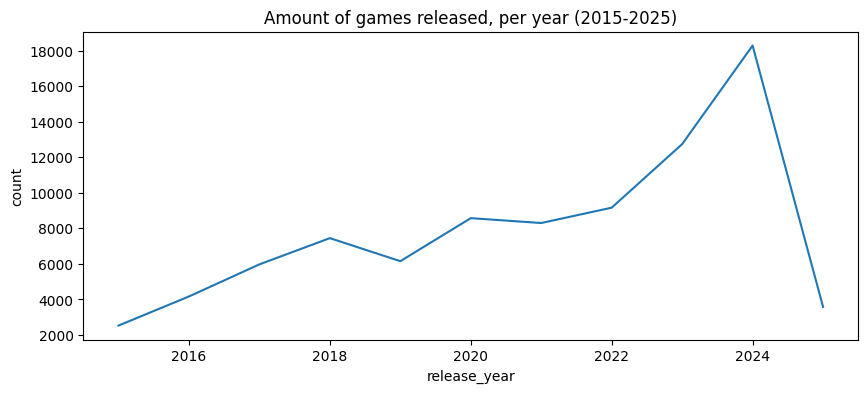

In [36]:
lineplot(game_years)
plt.title("Amount of games released, per year (2015-2025)")

The total amount of games (every genre) only seems to increase. The drop at the end might just indicate a small amount of games registered for 2025.

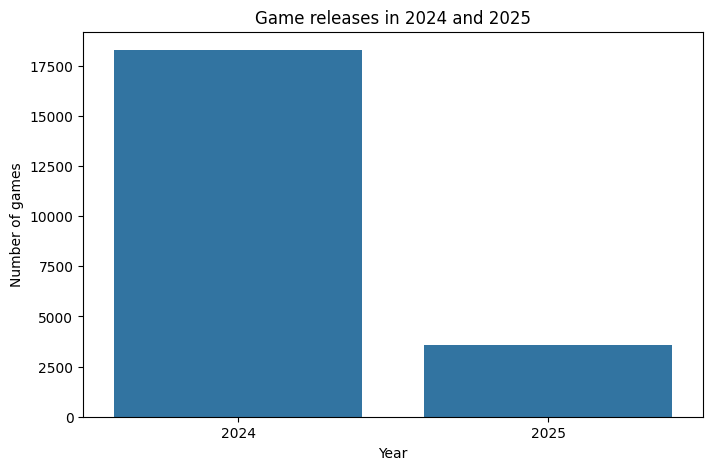

In [45]:
barplots(year_comp)
plt.title("Game releases in 2024 and 2025")
plt.ylabel("Number of games")
plt.xlabel("Year")
plt.show()

As we can see more precisely, there are a few 2025 games (3k+), but that must be because of the recency of the dataset. So we will have to take that into account for later, when we want to calculate the genre popularities per year.

----------------

---------------------

##### Step 2 : Transform data & further analysis

Our goal is to understand how the popularity of genres evolved. We understood that some genres/categories/tags were repetitive because of how popular they were (Indie, Solo-player, Action, Adventure...), but some  genres and tags *gained* popularity overtime. This is why we will now focus on creating **time series**, between genres, tags, and years.

In [4]:
#Getting genre popularity (by taking into account owners and amount of games per genre)

df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_genres = df.explode("genres")

genre_popularity = (df_genres.groupby(["release_year", "genres"], as_index=False).agg(total_owners=("total_est_owners", "sum"),n_games=("name", "count")))

genre_popularity.head()

,release_year,genres,total_owners,n_games
0,2015,Action,411020000,1089
1,2015,Adventure,304745000,983
2,2015,Animation & Modeling,8825000,14
3,2015,Audio Production,1585000,7
4,2015,Casual,141625000,759


**total_owners** = sum of estimated owners across every game in that year + genre. So in 2017, for example, 6 games (n_games) had an 'Accounting' genre with an overall estimatation of 255000 owners.

In [5]:
#Getting tag popularity. Reminder : tags are in dict format, not lists. More steps needed to convert them.

df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#We get the tags into multiple rows
df_tags = (
    df.assign(tags=df["tags"].apply(lambda d: list(d.items() if isinstance(d, dict) else [])))
      .explode("tags")
)

#We separate the tag names from the votes
df_tags[["tag", "votes"]] = pd.DataFrame(df_tags["tags"].tolist(), index=df_tags.index)

#We aggregate (year + tag), just as for genres previously. This time, we also take into account the total num of votes
tag_popularity = ( 
    df_tags.groupby(["release_year", "tag"], as_index=False) 
    .agg(total_owners=("total_est_owners", "sum"), 
        total_votes=("votes", "sum"), 
        n_games=("name", "count")) 
)

tag_popularity.head(10)

,release_year,tag,total_owners,total_votes,n_games
0,2015,1980s,8305000,1965.0,20
1,2015,1990's,13575000,3724.0,47
2,2015,2.5D,8840000,3183.0,39
3,2015,2D,175580000,52245.0,562
4,2015,2D Fighter,6165000,2625.0,26
5,2015,2D Platformer,3770000,5597.0,45
6,2015,3D,66840000,14478.0,77
7,2015,3D Fighter,3860000,1867.0,3
8,2015,3D Platformer,5780000,2816.0,46
9,2015,3D Vision,9745000,1015.0,7


In [ ]:
#Getting tag combinations

df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#getting tags like {Shooter, Survival, Horror} into pairs "Shooter, Survival" / "Survival, Horror" etc. 
#sorted prevents "Shooter, Survival" & "Survival, Shooter" from being two separate pairs
def tag_combination(d):
    if isinstance(d, dict):
        keys = list(d.keys())
        if len(keys) >= 2:
            return [", ".join(sorted(c)) for c in combinations(keys, 2)]
        
df["tag_combos"] = df["tags"].apply(tag_combination)

df_combos = df.explode("tag_combos")

#cleaning df from empty combinations/keeping the normal combinations by filtering the empty ones/NaN out
df_combos = df_combos[df_combos["tag_combos"].notna() & (df_combos["tag_combos"] != "")]

combo_popularity = (
    df_combos.groupby(["release_year", "tag_combos"], as_index=False)
             .agg(total_owners=("total_est_owners", "sum"),
                  n_games=("name", "count"))
)

combo_popularity.head()

,release_year,tag_combos,total_owners,n_games
0,2015,"1980s, 1990's",4115000,8
1,2015,"1980s, 2D",8145000,14
2,2015,"1980s, 2D Fighter",425000,2
3,2015,"1980s, 2D Platformer",350000,1
4,2015,"1980s, 4 Player Local",3545000,3


##### Some more visualisation with the new variables

In [34]:
genre_popularity["growth"] = genre_popularity.groupby("genres")["total_owners"].pct_change()